<a href="https://colab.research.google.com/github/cfoli/Kinematic-Decoding-4-BCI-Control/blob/main/Two_finger_neural_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utility Functions

---



In [2]:

def bin_spikes(spikes, bin_size):

    """
    Bin spikes in time.

    Inputs
    ------
    spikes: numpy array of spikes (neurons x time)

    bin_size: number of time points to pool into a time bin

    Outputs
    -------
    S: numpy array of spike counts (neurons x bins)

    """

    # Get some useful constants.
    [N, n_time_samples] = spikes.shape
    K = int(n_time_samples/bin_size) # number of time bins

    # Count spikes in bins.
    S = np.empty([N, K])
    for k in range(K):
        S[:, k] = np.sum(spikes[:, k*bin_size:(k+1)*bin_size], axis=1)

    return S


In [3]:

def append_history(neural_data, targ_data=None, num_bins_before=1):
    """
    Create a time-lagged feature matrix from neural data by appending neural activity
    from the current and previous time bins.

    Parameters
    ----------
    neural_data : ndarray of shape (n_time_bins, n_neurons)
        Neural features over time.

    targ_data : ndarray of shape (n_time_bins, n_outputs), optional
        Corresponding target data to be trimmed in alignment with the lagged neural data.

    num_bins_before : int, optional (default=1)
        Number of time bins *before* the current bin to include.

    Returns
    -------
    X : ndarray of shape (n_time_bins - num_bins_before, (num_bins_before + 1) * n_neurons)
        Time-lagged and flattened neural features.

    y : ndarray of shape (n_time_bins - num_bins_before, n_outputs) or None
        Trimmed target data (if provided), aligned with output X.
    """
    if num_bins_before < 0:
        raise ValueError("num_bins_before must be non-negative")

    if neural_data.ndim != 2:
        raise ValueError("neural_data must be 2D (time, features)")

    n_time_bins, n_neurons = neural_data.shape
    window_size = num_bins_before + 1

    if n_time_bins <= num_bins_before:
        raise ValueError("Not enough time bins to apply specified history length.")

    # Create empty array with NaNs for early time bins
    X = np.full((n_time_bins, window_size, n_neurons), np.nan)

    # Fill the design matrix with lagged data
    for i in range(num_bins_before, n_time_bins):
        X[i] = neural_data[i - num_bins_before:i + 1]

    # Flatten history dimension (time x (lag * features))
    X = X.reshape(n_time_bins, -1)

    # Remove first num_bins_before rows (incomplete history)
    X = X[num_bins_before:, :]

    y = targ_data[num_bins_before:, :] if targ_data is not None else None

    return X, y


In [4]:

import numpy as np

def append_history_cnn(neural_data, targ_data=None, num_bins_before=1):
    """
    Appends time-lagged history to the neural input.

    Parameters
    ----------
    neural_data : ndarray, shape (T, N)
        Raw neural activity over time (time x channels).
    targ_data : ndarray, shape (T, D), optional
        Target values (e.g., kinematics) over time.
    num_bins_before : int
        Number of previous bins to include in addition to the current bin.

    Returns
    -------
    X : ndarray, shape (T - num_bins_before, num_bins_before + 1, N)
        History-augmented neural input.
    y : ndarray or None
        Trimmed target array, or None if targ_data not provided.
    """
    T, N = neural_data.shape
    window = num_bins_before + 1
    X = np.full((T, window, N), np.nan)

    for i in range(num_bins_before, T):
        X[i] = neural_data[i - num_bins_before:i + 1]

    X = X[num_bins_before:]
    y = targ_data[num_bins_before:] if targ_data is not None else None
    return X, y


In [5]:

def plot_targets(targ, fing_color, targ_radius = 0.075, x_lim=None, y_pred=None, plot_targ_TF=False):

  if x_lim is None:
    x_lim = [0, len(targ)]

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd

  # Find transitions in target display
  targ_starts = np.concatenate(([0], np.where(np.diff(targ) != 0)[0] + 1))

  # Compute the duration (W) of each target
  targ_durations = np.diff(np.append(targ_starts, len(targ)))  # Ensuring last target is included

  # Compute target heights
  # targ_half_height = targsize[targ_starts].flatten()  # Select correct column
  targ_height = 2 * targ_radius  # Full height = 2 * R
  targ_locs = targ[targ_starts] - targ_radius  # Compute Y positions

  # Plot the targets as rectangles
  fig, ax = plt.subplots(figsize=(22, 3), dpi=300)
  if plot_targ_TF:
    ax.plot(range(len(targ)), targ, 'k', linewidth=0.5, linestyle='-', zorder=1)  # Plot the target trajectory

  # Draw rectangles
  for i in range(len(targ_starts)):
      rect = plt.Rectangle((targ_starts[i], targ_locs[i]),
                          targ_durations[i], targ_height,
                          edgecolor='k', facecolor=fing_color['target'],
                          alpha=0.5, linestyle='--', linewidth=0.5, zorder=2)
      ax.add_patch(rect)

  if y_pred is not None:
    ax.plot(range(len(y_pred)), y_pred, fing_color['line'], linewidth=2, linestyle='-', zorder=3)  # Plot the target trajectory

  ax.spines[:].set_visible(False)

  ax.set_xlim(x_lim[0], x_lim[-1])

  # Configure plot
  ax.set_xlabel('Time (samples)',fontsize=18,labelpad=10)
  ax.set_ylabel('Extension',fontsize=18,labelpad=10)
  ax.set_title('Kinematic Targets',fontsize=20)
  ax.tick_params(axis='both', which='major', labelsize=14)
  ax.grid(False)
  plt.show()


In [6]:
import numpy as np

def extend_kinematics_from_position(targ_pos_binned, bin_width, compute='velocity'):
    """
    Extends target position data to include velocity and/or acceleration.

    Parameters:
    -----------
    targ_pos_binned : np.ndarray
        Array of shape [t, d], where t is time and d is the number of spatial dimensions.
    bin_width : float
        Time interval between consecutive position samples.
    compute : str
        One of {'velocity', 'acceleration', 'both'} indicating which kinematics to compute.

    Returns:
    --------
    y_kf : np.ndarray
        Extended array of shape [t, d*k], where k = 1 (position + one of velocity/acceleration)
        or k = 2 (position + velocity + acceleration), ordered as [position, velocity, acceleration].
    """
    if compute not in ['velocity', 'acceleration', 'both']:
        raise ValueError("compute must be one of {'velocity', 'acceleration', 'both'}")

    # Check dimensionality
    if targ_pos_binned.ndim == 1:
        # If 1D, reshape to 2D with single spatial dimension
        targ_pos_binned = targ_pos_binned.reshape(-1, 1)

    t, d = targ_pos_binned.shape
    vel = acc = None

    if compute in ['velocity', 'both']:
        vel = np.diff(targ_pos_binned, axis=0) / bin_width
        vel = np.vstack((vel, vel[-1]))  # Keep same length by repeating last row

    if compute in ['acceleration', 'both']:
        if vel is None:
            vel_temp = np.diff(targ_pos_binned, axis=0) / bin_width
            vel_temp = np.vstack((vel_temp, vel_temp[-1]))
        else:
            vel_temp = vel
        acc = np.diff(vel_temp, axis=0) / bin_width
        acc = np.vstack((acc, acc[-1]))

    # Stack based on compute flag
    components = [targ_pos_binned]
    if compute == 'velocity':
        components.append(vel)
    elif compute == 'acceleration':
        components.append(acc)
    elif compute == 'both':
        components.extend([vel, acc])

    y_kf = np.hstack(components)
    return y_kf


### Standard Kalman Filter

---



In [7]:
import numpy as np
from numpy.linalg import inv
from sklearn.preprocessing import StandardScaler

class KalmanFilter(object):
    """
    Kalman Filter for neural decoding based on the Kording/Wu et al. 2003 framework.

    Adds support for using a fixed initial state (`z0`) and initial uncertainty (`P0`)
    computed from training data. This avoids dependence on ground-truth during inference.

    Attributes
    ----------
    C : float
        Scaling factor for process noise (W). Controls how much to trust the dynamics.

    model : dict
        Contains trained parameters:
            - A: State transition matrix
            - W: Process noise covariance
            - H: Observation matrix
            - Q: Observation noise covariance
            - z0: Initial state mean (column vector)
            - P0: Initial state covariance matrix
    """

    def __init__(self, C=1, O=1):
        """
        Initializes the Kalman filter object.

        Parameters
        ----------
        C : float, optional (default=1)
            Scaling factor for process noise (W). Increasing C reduces the weight of
            the dynamics (A) during filtering.
        O : int, optional (default=1)
            Autoregressive model order for the state model (must be >= 1). O controls how many past time steps are used to predict the next state. A larger O models long-term temporal dependencies.
        """
        self.C = C
        assert O >= 1, "Autoregressive order O must be >= 1"
        self.O = O

        self.data_preprocessor = StandardScaler() # Z-score neural data
        self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data

        self.used_PCA_TF = False # flag to tell predict() whether or not training used PCA

    def fit(self, X_train, y_train, use_PCA_TF=False, PC_thresh=None):
        """
        Train the Kalman Filter model using paired neural and behavioral data.

        Parameters
        ----------
        X_train : ndarray of shape [n_samples, n_neurons]
            Neural features (observations).
        use_PCA_TF : boolean scalar
            Transform neural data using PCA if true?
        PC_thresh : float or int scalar
            If int: Number of principal components to keep.
            If float: Proportion of variance to keep.
        y_train : ndarray of shape [n_samples, n_outputs]
            Behavioral variables (true hidden states).
        """

        # Run PCA if true
        if use_PCA_TF:
          self.used_PCA_TF = True
          self.num_PCs = None
          from sklearn.decomposition import PCA
          self.pca_transformer = PCA()
          self.pca_transformer.fit(X_train)

          if isinstance(PC_thresh,float) and PC_thresh>0:
              explained_var_cumsum = np.cumsum(self.pca_transformer.explained_variance_ratio_)
              self.num_PCs = np.where(explained_var_cumsum <= PC_thresh)[0][-1]
          elif isinstance(PC_thresh,int) and PC_thresh>0:
              self.num_PCs = PC_thresh

          X_train = self.pca_transformer.transform(X_train)[:, :self.num_PCs]

        # scale neural features
        X_train   = self.data_preprocessor.fit_transform(X_train)
        y_train   = self.targ_transformer.fit_transform(y_train)

        X  = np.matrix(y_train.T)  # Hidden state (e.g., kinematics)
        Z  = np.matrix(X_train.T)  # Observations (e.g., spikes)
        nt = X.shape[1]  # Number of time steps

        # Fit state transition matrix (A) and process noise (W)
        o = self.O  # autoregressive model order
        X2 = X[:, o:]
        X1 = X[:, 0:nt - o]
        A = X2 @ X1.T @ inv(X1 @ X1.T)
        W = (X2 - A @ X1) @ (X2 - A @ X1).T / (nt - o) / self.C

        # Fit observation matrix (H) and observation noise (Q)
        H = Z @ X.T @ inv(X @ X.T)
        Q = (Z - H @ X) @ (Z - H @ X).T / nt

        # Initial state: use first state from training
        z0 = np.asarray(X[:, 0]).flatten()  # Initial state vector

        # Initial uncertainty: small identity matrix
        P0 = np.eye(X.shape[0]) * 1e-3

        # Store model parameters
        self.model = {
            'A': A,
            'W': W,
            'H': H,
            'Q': Q,
            'z0': z0,
            'P0': P0
        }

    def predict(self, X_pred):
        """
        Predict hidden states from neural observations using the trained Kalman Filter.

        This method initializes the filter with the precomputed `z0` and `P0` from training.

        Parameters
        ----------
        X_pred : ndarray of shape [n_samples, n_neurons]
            Neural features to decode.

        Returns
        -------
        y_pred : ndarray of shape [n_samples, n_outputs]
            Estimated hidden states (e.g., positions or velocities).
        """

        if self.used_PCA_TF:
          X_pred = self.pca_transformer.transform(X_pred)[:, :self.num_PCs]

        X_pred = self.data_preprocessor.transform(X_pred)

        # Load model parameters
        A = self.model['A']
        W = self.model['W']
        H = self.model['H']
        Q = self.model['Q']
        z0 = self.model['z0']
        P0 = self.model['P0']

        Z = np.matrix(X_pred.T)
        num_states = A.shape[0]
        num_timesteps = Z.shape[1]

        # Initialize state and covariance
        states = np.empty((num_states, num_timesteps))
        P = np.matrix(P0)
        state = np.matrix(z0).T  # Ensure column vector

        # Set initial state
        states[:, 0] = np.asarray(state).flatten()

        # Kalman filtering loop
        for t in range(num_timesteps - 1):
            # Predict next state
            P_m = A @ P @ A.T + W
            state_m = A @ state

            # Kalman gain
            K = P_m @ H.T @ np.linalg.inv(H @ P_m @ H.T + Q)

            # Update state
            state = state_m + K @ (Z[:, t + 1] - H @ state_m)
            P = (np.eye(num_states) - K @ H) @ P_m

            # Store prediction
            states[:, t + 1] = np.asarray(state).flatten()

        # ----------- Aliases -----------
        # H is sometimes denoted as C in literature, and represents the transformation that converts kinematics to neural features
        # Z is sometimes denoted y and represents the observed neural features
        # -------------------------------

        # Return predicted states (time x features)...after undoing zero-centering
        return self.targ_transformer.inverse_transform(states.T)


### ReFIT-Kalman Filter

---





In [8]:
import numpy as np
from numpy.linalg import inv

class ReFITKalmanFilter(KalmanFilter):
    """
    ReFIT Kalman Filter (Gilja et al., 2012) using intention-aligned training and optional
    position feedback correction during decoding.

    This subclass extends KalmanFilter_zeroInit by:

    1. Modifying the training targets to reflect intended velocities based on position and target.
    2. Supporting velocity reorientation methods: "flip", "rotate", or "both".
    3. Allowing optional velocity zeroing when inside the target.

    Parameters
    ----------
    C : float
        Scaling factor for process noise in KalmanFilter_zeroInit.
    alpha : float
        Velocity blending factor during training (used for rotation).
    velocity_rot_method : str
        Velocity correction method: 'flip', 'rotate', or 'both'.
    zero_vel_on_target_TF : bool
        If True, zero velocity when inside target radius.
    """
    def __init__(self, C=1, alpha=0.8, velocity_rot_method="flip", zero_vel_on_target_TF=False):
        super().__init__(C)
        self.alpha = alpha
        self.velocity_rot_method = velocity_rot_method.lower()
        self.zero_vel_on_target_TF = zero_vel_on_target_TF

    def _compute_flipped_velocity(self, pos, vel, targ, targsize):
        """Flip velocity if moving away from the target."""
        v_flip = vel.copy()
        T, D = pos.shape
        for t in range(T):
            for d in range(D):
                if targ[t, d] == -1:
                    continue
                dist = pos[t, d] - targ[t, d]
                hit = abs(dist) < targsize
                if self.zero_vel_on_target_TF and hit:
                    v_flip[t, d] = 0
                elif (dist < 0 and v_flip[t, d] < 0) or (dist > 0 and v_flip[t, d] > 0):
                    v_flip[t, d] *= -1
        return v_flip

    def _compute_rotated_velocity(self, pos, vel, targ, targsize):
        """Rotate velocity to point toward the target direction."""
        v_rot = vel.copy()
        T, D = pos.shape
        targ = targ[:, :D]  # Only keep position dimensions

        for t in range(T):
            good_dims = targ[t] != -1
            if not np.any(good_dims):
                continue
            vec_to_target = targ[t, good_dims] - pos[t, good_dims]
            norm_vec = np.linalg.norm(vec_to_target)
            if norm_vec > 1e-5:
                speed = np.linalg.norm(v_rot[t, good_dims])
                v_rot[t, good_dims] = (vec_to_target / norm_vec) * speed
                if self.zero_vel_on_target_TF:
                    hit_mask = np.zeros_like(good_dims)
                    hit_mask[good_dims] = np.abs(pos[t, good_dims] - targ[t, good_dims]) < targsize
                    v_rot[t, hit_mask] = 0
        return v_rot

    def compute_intended_trajectory(self, y_train, targets, targsize):
        """
        Modifies training trajectories to align velocity with target using selected strategy.

        Parameters
        ----------
        y_train : ndarray of shape [T, 2*D]
            Original training behavior data [position, velocity].
        targets : ndarray of shape [T, D]
            Target positions.
        targsize : scalar
            Target size threshold for each time point.

        Returns
        -------
        y_refit : ndarray of shape [T, 2*D]
            Modified training data with position and reoriented velocity.
        """
        T, total_dims = y_train.shape
        D = total_dims // 2
        pos = y_train[:, :D]
        vel = y_train[:, D:]

        if self.velocity_rot_method == "rotate":
            vel_new = self._compute_rotated_velocity(pos, vel, targets, targsize)
            pos_new = pos
        elif self.velocity_rot_method == "flip":
            vel_new = self._compute_flipped_velocity(pos, vel, targets, targsize)
            pos_new = pos

        else:
            raise ValueError("Invalid velocity_rot_method. Must be 'flip' or 'rotate'.")

        return np.hstack([pos_new, vel_new])

    def fit(self, X_kf_train, y_train, targets=None, targsize=None):
        """
        Fits the Kalman Filter using intention-aligned trajectories if targets and targsize are given.

        Parameters
        ----------
        X_kf_train : ndarray
            Neural input data.
        y_train : ndarray
            Original behavioral training data [position, velocity].
        targets : ndarray, optional
            Target positions corresponding to each training time step.
        targsize : ndarray, optional
            Target radius threshold for each time step.
        """
        if targets is not None and targsize is not None:
            y_train_rotated = self.compute_intended_trajectory(y_train, targets, targsize)
        super().fit(X_kf_train, y_train_rotated)

    def predict(self, X_kf_test, position_feedback=None):
        """
        Decodes neural data and optionally replaces predicted position with known position feedback.

        Parameters
        ----------
        X_kf_test : ndarray
            Neural test data.
        position_feedback : ndarray, optional
            Known position data to replace decoded positions.

        Returns
        -------
        states : ndarray
            Decoded behavioral states.
        """
        states = super().predict(X_kf_test)
        if position_feedback is not None:
            states[:, :position_feedback.shape[1]] = position_feedback
        return states


In [9]:

def _compute_rotated_velocity(pos, vel, targ, targsize):
  """Rotate velocity to point toward the target direction."""
  v_rot = vel.copy()
  T, D = pos.shape
  targ = targ[:, :D]  # Only keep position dimensions

  for t in range(T):
      good_dims = targ[t] != -1
      if not np.any(good_dims):
          continue
      vec_to_target = targ[t, good_dims] - pos[t, good_dims]
      norm_vec = np.linalg.norm(vec_to_target)
      if norm_vec > 1e-5:
          speed = np.linalg.norm(v_rot[t, good_dims])
          v_rot[t, good_dims] = (vec_to_target / norm_vec) * speed

          hit_mask = np.zeros_like(good_dims)
          hit_mask[good_dims] = np.abs(pos[t, good_dims] - targ[t, good_dims]) < targsize
          v_rot[t, hit_mask] = 0
  return v_rot


In [184]:
T, total_dims = targ.shape
D = total_dims // 2
pos = targ[:, :D]
vel = targ[:, D:]

vel_new = _compute_rotated_velocity(pos, vel, targ_feedback, 0.75)


In [185]:
import numpy as np

def rotate_towards(y_pred_feedback, y_targ):
    direction = y_targ / np.linalg.norm(y_targ)  # unit vector in direction of target
    magnitude = np.linalg.norm(y_pred_feedback)
    return magnitude * direction
targ_new = rotate_towards(targ_feedback[:,1],targ[:,1])

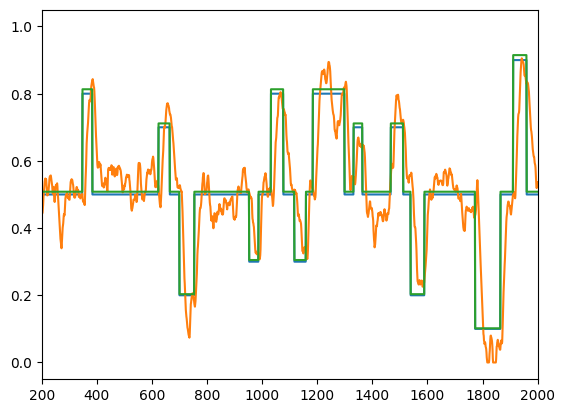

In [189]:
plt.plot(targ[:,1])
plt.plot(targ_feedback[:,1])
plt.plot(targ_new)
plt.xlim(200,2000)
plt.show()

### Wiener Filter (Unregularized Linear Regression)

---



In [10]:

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

class WienerFilterDecoder(object):

    """
    Class for the Wiener Filter Decoder

    There are no parameters to set.

    This simply leverages the scikit-learn linear regression.
    """

    def __init__(self):
        self.data_preprocessor = StandardScaler() # Z-score neural data
        self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data
        self.model = LinearRegression()

    def fit(self,X_train,y_train,num_bins_before=3):

        """
        Train Wiener Filter Decoder

        Parameters
        ----------
        X_train: numpy 2d array of shape [n_samples,n_features]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """
        # ---------------- Preprocess Training Data --------------
        self.num_bins_before = num_bins_before

        # Get the covariate matrix that includes spike history from previous bins
        X_train, y_train = append_history(X_train, targ_data=y_train,num_bins_before = num_bins_before)

        X_train = self.data_preprocessor.fit_transform(X_train)
        y_train = self.targ_transformer.fit_transform(y_train)

        #----------------------------------------------------------
        self.model.fit(X_train, y_train) #Train the model


    def predict(self,X_pred):

        """
        Predict outcomes using trained Wiener Cascade Decoder

        Parameters
        ----------
        X_pred: numpy 2d array of shape [n_samples,n_features]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_pred: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """
        # ----------- Preprocess Test (Prediction) Data -------------
        num_bins_before = self.num_bins_before

        # Get the covariate matrix that includes spike history from previous bins
        X_pred,_ = append_history(X_pred, num_bins_before = num_bins_before)

        X_pred = self.data_preprocessor.transform(X_pred) # Z-score neural data

        # ------------------------------------------------------------
        y_pred = self.model.predict(X_pred) # Make predictions

        y_pred = self.targ_transformer.inverse_transform(y_pred) # Undo zero-centering

        return y_pred


### Ridge Regression Decoder

---



In [11]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import numpy as np

class RidgeDecoder(object):
    """
    Ridge Regression-based Decoder.

    Includes history stacking and standardization of input features (Z-scoring) and
    zero-centering of targets.
    """

    def __init__(self, alpha=1.0):
        """
        Parameters
        ----------
        alpha : float
            Regularization strength for Ridge regression.
        """
        self.alpha = alpha
        self.data_preprocessor = StandardScaler()  # Z-score neural data
        self.targ_transformer  = StandardScaler(with_std=False)  # Zero-center target
        self.model = Ridge(alpha=self.alpha, max_iter=10000)

    def fit(self, X_train, y_train, num_bins_before=3):
        """
        Train the Ridge Wiener Filter decoder.

        Parameters
        ----------
        X_train : ndarray, shape (n_samples, n_features)
            Neural activity data.

        y_train : ndarray, shape (n_samples, n_outputs)
            Target output data (e.g., cursor velocity).

        num_bins_before : int
            Number of history bins to include before the current bin.
        """
        self.num_bins_before = num_bins_before

        # Create history-augmented neural data
        X_train_hist, y_train_trimmed = append_history(X_train, y_train, num_bins_before)

        # Standardize input and target data
        X_train_scaled   = self.data_preprocessor.fit_transform(X_train_hist)
        y_train_centered = self.targ_transformer.fit_transform(y_train_trimmed)

        # Train Ridge regression model
        self.model.fit(X_train_scaled, y_train_centered)

    def predict(self, X_pred):
        """
        Predict output using trained decoder.

        Parameters
        ----------
        X_pred : ndarray, shape (n_samples, n_features)
            Neural activity data for prediction.

        Returns
        -------
        y_pred : ndarray, shape (n_samples - num_bins_before, n_outputs)
            Predicted target outputs.
        """
        num_bins_before = self.num_bins_before

        # Apply same history transformation and scaling
        X_pred_hist, _ = append_history(X_pred, None, num_bins_before)
        X_pred_scaled  = self.data_preprocessor.transform(X_pred_hist)

        # Predict and un-center the predictions
        y_pred_centered = self.model.predict(X_pred_scaled)
        y_pred = self.targ_transformer.inverse_transform(y_pred_centered)

        return y_pred


### Ensemble Learner (XGBoost)

---



In [12]:
import numpy as np
import xgboost as xgb
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

class XGBoostMultiOutputDecoder(BaseEstimator, RegressorMixin):
    """
    XGBoost-based decoder for multidimensional regression using a single model,
    with support for input history stacking, optional validation data, and early stopping.

    Parameters
    ----------
    max_depth : int
        Maximum depth of trees.
    num_round : int
        Maximum number of boosting rounds.
    eta : float
        Learning rate.
    num_bins_before : int
        Number of past bins to include as time history.
    patience : int or None
        If set, enables early stopping with validation set (after patience rounds of no performance improvement).
    """

    def __init__(self, max_depth=3, num_round=300, eta=0.3, min_child_weight=2, subsample = 0.5, colsample_bytree=0.8, num_bins_before=3, patience=10,val_verbose=False):
        self.max_depth = max_depth
        self.num_round = num_round
        self.eta = eta
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.num_bins_before = num_bins_before
        self.patience = patience
        self.val_verbose = val_verbose

        self.model = None
        self.data_preprocessor = StandardScaler()
        self.target_centerer = StandardScaler(with_std=False)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Fit model with optional validation for early stopping.

        Parameters
        ----------
        X : ndarray, shape (T, N)
            Training neural features.

        y : ndarray, shape (T, D)
            Training targets.

        X_val : ndarray, optional
            Validation neural features.

        y_val : ndarray, optional
            Validation targets.
        """
        X_train_hist, y_train_hist = append_history(X, y, self.num_bins_before)
        X_train_scaled = self.data_preprocessor.fit_transform(X_train_hist)
        y_train_centered = self.target_centerer.fit_transform(y_train_hist)

        dtrain = xgb.DMatrix(X_train_scaled, label=y_train_centered)

        evals = []
        evals_result = {}

        if X_val is not None and y_val is not None:
            X_val_hist, y_val_hist = append_history(X_val, y_val, self.num_bins_before)
            X_val_scaled = self.data_preprocessor.transform(X_val_hist)
            y_val_centered = self.target_centerer.transform(y_val_hist)

            dval = xgb.DMatrix(X_val_scaled, label=y_val_centered)
            evals = [(dtrain, "train"), (dval, "val")]
        else:
            evals = [(dtrain, "train")]

        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': self.max_depth,
            'eta': self.eta,
            'min_child_weight': self.min_child_weight,
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree,
            'verbosity': 0}

        self.model = xgb.train(
            params,
            dtrain,
            num_boost_round=self.num_round,
            evals=evals,
            evals_result=evals_result,
            early_stopping_rounds=self.patience if len(evals) > 1 else None,
            verbose_eval=self.val_verbose
        )

        return self

    def predict(self, X):
        """
        Predict from neural data.

        Parameters
        ----------
        X : ndarray, shape (T, N)
            Neural input.

        Returns
        -------
        y_pred : ndarray, shape (T - num_bins_before, D)
            Predicted targets.
        """
        X_hist, _ = append_history(X, None, self.num_bins_before)
        X_scaled = self.data_preprocessor.transform(X_hist)
        dtest = xgb.DMatrix(X_scaled)

        y_pred_centered = self.model.predict(dtest)
        y_pred = self.target_centerer.inverse_transform(y_pred_centered)
        return y_pred


### Feed Forward Neural Network

---



In [13]:

from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

import numpy as np

class FeedForwardNNDecoder(object):

    """
    Class for the dense (fully-connected) neural network decoder

    Parameters
    ----------

    units: integer or vector of integers, optional, default 400
        This is the number of hidden units in each layer
        If you want a single layer, input an integer (e.g. units=400 will give you a single hidden layer with 400 units)
        If you want multiple layers, input a vector (e.g. units=[400,200]) will give you 2 hidden layers with 400 and 200 units, repsectively.
        The vector can either be a list or an array

    dropout: decimal, optional, default 0
        Proportion of units that get dropped out

    num_epochs: integer, optional, default 10
        Number of epochs used for training

    verbose: binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """

    def __init__(self,units=64, dropout=0.25, batch_size=32, num_epochs=100, verbose=1):
         self.dropout    = dropout
         self.num_epochs = num_epochs
         self.batch_size = batch_size
         self.verbose    = verbose

         self.num_bins_before = None

         #If "units" is an integer, put it in the form of a vector
         try: #Check if it's a vector
             units[0]
         except: #If it's not a vector, create a vector of the number of units for each layer
             units=[units]
         self.units=units

         #Determine the number of hidden layers (based on "units" that the user entered)
         self.num_layers=len(units)

         self.data_preprocessor = StandardScaler() # Z-score neural data
         self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data


    def fit(self,X_train,y_train, val_data = None, num_bins_before=3, early_stopping_TF = True, patience = 20):

        """
        Train DenseNN Decoder

        Parameters
        ----------
        X_train: numpy 2d array of shape [n_samples,n_features]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """
        # ---------------- Preprocess Training Data --------------
        self.num_bins_before = num_bins_before
        # Get the covariate matrix that includes spike history from previous bins
        X_train, y_train = append_history(X_train, targ_data = y_train, num_bins_before = num_bins_before)

        X_train = self.data_preprocessor.fit_transform(X_train)
        y_train = self.targ_transformer.fit_transform(y_train)

        # ----------- Preprocess Validation Data, if Available -----------

        callbacks = []
        # preprocess validation set
        if val_data is not None:
          val_data[0] = append_history(val_data[0], num_bins_before = num_bins_before)
          val_data[0] = val_data[0].reshape(val_data[0].shape[0], -1)
          val_data[0] = val_data[0][num_bins_before:,:]
          val_data[0] = self.data_preprocessor.fit_transform(val_data[0])

          val_data[1] = val_data[1][num_bins_before:,:]
          val_data[1] = self.targ_transformer.fit_transform(val_data[1])

          if early_stopping_TF:
            from keras.callbacks import EarlyStopping
            early_stop = EarlyStopping(monitor   = 'val_loss',
                                        patience = patience,
                                        restore_best_weights=True,
                                        verbose=0)
            callbacks.append(early_stop)

        model=Sequential() #Declare model
        #Add first hidden layer
        model.add(Input(shape=(X_train.shape[1],)))
        model.add(Dense(self.units[0])) #Add dense layer
        model.add(Activation('relu')) #Add nonlinear (tanh) activation
        # if self.dropout!=0:
        if self.dropout!=0: model.add(Dropout(self.dropout))  #Dropout some units if proportion of dropout != 0

        #Add any additional hidden layers (beyond the 1st)
        for layer in range(self.num_layers-1): #Loop through additional layers
            model.add(Dense(self.units[layer+1])) #Add dense layer
            model.add(Activation('relu')) #Add nonlinear (tanh) activation
            if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units if proportion of dropout != 0

        #Add dense connections to all outputs
        model.add(Dense(y_train.shape[1])) #Add final dense layer (connected to outputs)

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer=Adam(learning_rate=1e-4),metrics=['mse']) #Set loss function and optimizer

        model.fit(X_train,
                  y_train,epochs = self.num_epochs,
                  batch_size     = self.batch_size,
                  validation_data= val_data,
                  callbacks      = callbacks,
                  verbose        = self.verbose) #Fit the model

        self.model=model

    def predict(self,X_pred):

        """
        Predict outcomes using trained DenseNN Decoder

        Parameters
        ----------
        X_pred: numpy 2d array of shape [n_samples,n_features]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_pred: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        # ----------- Preprocess Test (Prediction) Data -------------
        num_bins_before = self.num_bins_before

        # Get the covariate matrix that includes spike history from previous bins
        X_pred, _ = append_history(X_pred, num_bins_before = num_bins_before)

        X_pred = self.data_preprocessor.transform(X_pred) #Z-score neural data

        # ------------------------------------------------------------
        y_pred = self.model.predict(X_pred) # Make predictions

        y_pred = self.targ_transformer.inverse_transform(y_pred) #Undo zero-centering
        return y_pred



### CNN-FeedForward Hybrid Neural Network

---



In [14]:

import tensorflow as tf
from tensorflow.keras.layers import (Input, BatchNormalization, Conv1D, Dense,
                                     Dropout, Flatten, Permute, ReLU)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class CNN_FeedForwardNNDecoder:
    """
    CNN + Feedforward Neural Network decoder with built-in history stacking.

    This model accepts raw neural data of shape (T, N), appends a time window of
    past activity, and uses a combination of 1D convolution and dense layers for regression.

    Parameters
    ----------
    hidden_size : int
        Number of units in each fully connected layer.
    ConvSizeOut : int
        Number of filters in the Conv1D layer.
    num_outputs : int
        Number of continuous regression outputs.
    learning_rate : float, default=1e-3
        Optimizer learning rate.
    dropout_rate : float, default=0.5
        Dropout rate for regularization.
    num_bins_before : int, default=3
        Number of history bins to include before the current bin.
    """

    def __init__(self, hidden_size=256, ConvSizeOut=16,
                 learning_rate=1e-3, dropout_rate=0, num_bins_before=3):
        self.hidden_size     = hidden_size
        self.ConvSizeOut     = ConvSizeOut
        self.learning_rate   = learning_rate
        self.dropout_rate    = dropout_rate
        self.num_bins_before = num_bins_before

        self.model       = None
        self.input_size  = None
        self.num_outputs = None

        self.used_PCA_TF = False # flag to tell predict() whether or not PCA was used during training

        self.data_preprocessor = StandardScaler() # Z-score neural data
        self.targ_transformer  = StandardScaler(with_std=False) # Zero-center target data


    def _build_model(self, input_size, num_outputs):
        """
        Build the internal Keras model after inferring input/output dimensions.

        Parameters
        ----------
        input_size : int
        num_outputs : int

        Returns
        -------
        model : tf.keras.Model
        """
        input_tensor = Input(shape=(self.num_bins_before + 1, input_size), name='Input')
        x = BatchNormalization(name='BN0')(input_tensor)
        x = Permute((2, 1), name='Permute')(x)  # (batch, channels, time)
        x = Conv1D(filters=self.ConvSizeOut, kernel_size=1, name='Conv1')(x)
        x = Flatten(name='Flatten')(x)

        for i in range(3):
            x = Dense(self.hidden_size, kernel_initializer='he_normal', name=f'FC{i+1}')(x)
            x = Dropout(self.dropout_rate, name=f'Dropout{i+1}')(x)
            x = BatchNormalization(name=f'BN{i+2}')(x)
            x = ReLU(name=f'ReLU{i+1}')(x)

        output = Dense(num_outputs, kernel_initializer='he_normal', name='Output')(x)
        model = Model(inputs=input_tensor, outputs=output, name='CNN_FeedForwardNNDecoder')
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mean_squared_error',
            metrics=['mae']
        )
        return model


    def fit(self, X_train, y_train, use_PCA_TF=False, PC_thresh=None, batch_size=32, epochs=10,
            validation_data = None, verbose  = 1,
            early_stopping  = True, patience = 5, checkpoint_path = None):
        """
        Fit the model using raw neural and target data.

        Parameters
        ----------
        X_train : ndarray, shape (T, N)
            Raw training neural data.
        y_train : ndarray, shape (T, D)
            Training regression targets.
        validation_data : tuple or None
            Tuple of (X_val, y_val), both raw.
        early_stopping : bool, default=True
            Whether to use early stopping.
        patience : int, default=5
            Number of epochs to wait before stopping.
        checkpoint_path : str or None
            If given, saves best model weights to this path.
        """

        #------- Run PCA if true ------------
        if use_PCA_TF:
          self.used_PCA_TF = True
          self.num_PCs = None
          from sklearn.decomposition import PCA
          self.pca_transformer = PCA()
          self.pca_transformer.fit(X_train)

          if isinstance(PC_thresh,float) and PC_thresh>0:
              explained_var_cumsum = np.cumsum(self.pca_transformer.explained_variance_ratio_)
              self.num_PCs = np.where(explained_var_cumsum <= PC_thresh)[0][-1]
          elif isinstance(PC_thresh,int) and PC_thresh>0:
              self.num_PCs = PC_thresh

          X_train = self.pca_transformer.transform(X_train)[:, :self.num_PCs]

        # ---------- scale neural features ---------------
        X_train   = self.data_preprocessor.fit_transform(X_train)
        y_train   = self.targ_transformer.fit_transform(y_train)

        # ------------- Append history and infer shapes --------------
        X_hist, y_hist = append_history_cnn(X_train, y_train, self.num_bins_before)

        # if self.model is None:
        #     self.input_size  = X_hist.shape[2]
        #     self.num_outputs = y_hist.shape[1]
        #     self.model = self._build_model(self.input_size, self.num_outputs)
        self.input_size  = X_hist.shape[2]
        self.num_outputs = y_hist.shape[1]
        self.model = self._build_model(self.input_size, self.num_outputs)

        # Handle validation data
        val_data = None
        if validation_data is not None:
            X_val, y_val = validation_data

            if self.used_PCA_TF:
              X_val = self.pca_transformer.transform(X_val)[:, :self.num_PCs]

            X_val = self.data_preprocessor.transform(X_val)
            y_val = self.targ_transformer.transform(y_val)

            X_val_hist, y_val_hist = append_history_cnn(X_val, y_val, self.num_bins_before)
            val_data = (X_val_hist, y_val_hist)

        # Setup callbacks
        callbacks = []
        if early_stopping and val_data:
            callbacks.append(EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True))
        if checkpoint_path:
            callbacks.append(ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'))

        return self.model.fit(
            X_hist, y_hist,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=val_data,
            callbacks=callbacks,
            verbose=verbose
        )

    def predict(self, X_pred):
        """
        Predict using the trained model from raw neural input.

        Parameters
        ----------
        X_pred : ndarray, shape (T, N)
            Raw neural data.

        Returns
        -------
        y_pred : ndarray, shape (T - num_bins_before, D)
            Predicted target values.
        """

        if self.used_PCA_TF:
          X_pred = self.pca_transformer.transform(X_pred)[:, :self.num_PCs]

        X_pred = self.data_preprocessor.transform(X_pred)

        X_hist, _ = append_history_cnn(X_pred, None, self.num_bins_before)
        y_pred = self.model.predict(X_hist)
        y_pred = self.targ_transformer.inverse_transform(y_pred)
        return y_pred

    def summary(self):
        """Print the model architecture summary."""
        return self.model.summary()

    def save(self, path):
        """
        Save the full model to a file.

        Parameters
        ----------
        path : str
            Path to save the model (e.g., 'model.h5')
        """
        self.model.save(path)

    def load_weights(self, path):
        """
        Load weights from a checkpoint file.

        Parameters
        ----------
        path : str
            Path to weights file (e.g., 'best_weights.h5')
        """
        self.model.load_weights(path)


### Load Data

---



In [28]:
# Mar 14.25.F
from scipy.io import loadmat

file_name = 'MonkeyN_KC' # MonkeyN_KC, MonkeyN_RC, MonkeyW_KC, MonkeyW_RC
file_path = f'/content/drive/MyDrive/ML Projects/Two Finger Neural Decoding/Data/{file_name}.mat'

mat_data = loadmat(file_path)
targ     = mat_data['targ']  # num_bins x 2 (for two fingers)
targsize = mat_data['targsize']
neural_data = mat_data['X'] # num_bins x num_channels
trials = mat_data['trials']
targ_feedback = mat_data['y'] # predicted positions and associated velocities from the Kalman filter algorithm in use, prior to ReFIT manipulations. [T x 4]: [pos_1, pos_2, vel_1, vel_2]


In [29]:
targ_feedback.shape

(14459, 4)

In [16]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'targsize', 'X', 'targ', 'trials', 'y'])

In [17]:
print(f"Neural data shape: {neural_data.shape}")
print(f"Kinematic targets shape: {targ.shape}")


Neural data shape: (14459, 96)
Kinematic targets shape: (14459, 2)


In [53]:
from scipy.io import loadmat
import numpy as np

mat_data = loadmat('trialmats_speech_AIP.mat')


In [54]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'overtOrcovert', 'trialmataip', 'trialmataip_artreject', 'wordIndex'])

In [55]:
neural_data       = mat_data['trialmataip'] #
grasp_type        = mat_data['overtOrcovert']  #
# hand_open_close   = mat_data['handOpenOrClose']

In [56]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

def time_varying_decoder(neural_data, grasp_type, window_size=5, mode='flatten',
                         model='svm', **model_kwargs):
    """
    Time-varying neural decoder using a sliding window and specified classifier.

    Parameters:
    - neural_data: N x T x R array (N: electrodes, T: time bins, R: trials)
    - grasp_type: 1 x R array of labels
    - window_size: sliding window size (in time bins)
    - mode: 'flatten' (N * window_size) or 'mean' (N)
    - model: one of ['svm', 'nb', 'tree', 'knn']
    - model_kwargs: extra keyword arguments passed to the classifier

    Returns:
    - time_points: list of center time bins for each window
    - decoding_accuracy: list of cross-validated decoding accuracies
    """
    N, T, R = neural_data.shape
    grasp_type = np.array(grasp_type).flatten()

    time_points = []
    decoding_accuracy = []

    t_range = range(window_size // 2, T - window_size // 2)

    print(f"Starting decoding (mode = '{mode}', model = '{model}')...")
    for t in tqdm(t_range, desc="Decoding Progress"):
        # Extract neural window: N x window_size x R
        window_data = neural_data[:, t - window_size // 2 : t + window_size // 2 + 1, :]

        if mode == 'flatten':
            X = window_data.reshape(N * window_size, R).T  # R x (N * window_size)
        elif mode == 'mean':
            X = window_data.mean(axis=1).T  # R x N
        else:
            raise ValueError("mode must be 'flatten' or 'mean'")

        y = grasp_type

        # Select classifier
        if model == 'svm':
            clf = SVC(**model_kwargs)
        elif model == 'nb':
            clf = GaussianNB(**model_kwargs)
        elif model == 'tree':
            clf = DecisionTreeClassifier(**model_kwargs)
        elif model == 'knn':
            clf = KNeighborsClassifier(**model_kwargs)
        else:
            raise ValueError("model must be one of: 'svm', 'nb', 'tree', 'knn'")

        # Cross-validated accuracy
        acc = cross_val_score(clf, X, y, cv=5).mean()

        time_points.append(t)
        decoding_accuracy.append(acc)

    print("Decoding complete.")
    return time_points, decoding_accuracy


Starting decoding (mode = 'flatten', model = 'svm')...


Decoding Progress: 100%|██████████| 233/233 [00:07<00:00, 31.53it/s]


Decoding complete.


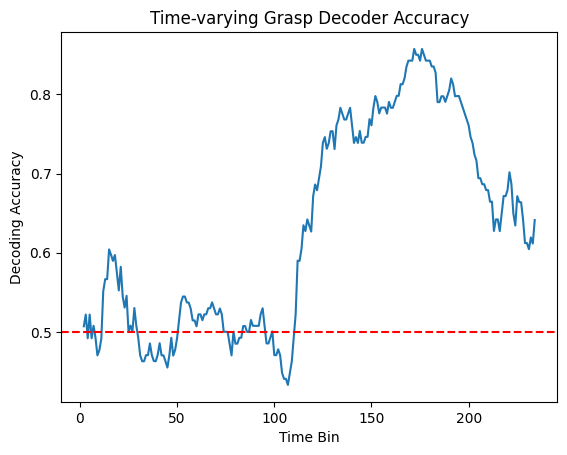

In [57]:

time_pts, accs = time_varying_decoder(neural_data, grasp_type, window_size=5, model='svm', kernel='rbf')

import matplotlib.pyplot as plt
plt.plot(time_pts, accs)
plt.axhline(y=0.5, color='r', linestyle='--', label=f'Chance Level')

plt.xlabel('Time Bin')
plt.ylabel('Decoding Accuracy')
plt.title('Time-varying Grasp Decoder Accuracy')
plt.show()


Starting decoding (mode = 'flatten', model = 'svm')...


Decoding Progress: 100%|██████████| 233/233 [00:18<00:00, 12.68it/s]


Decoding complete.


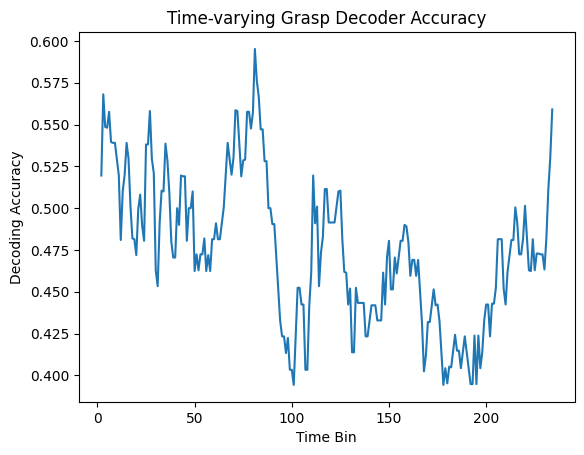

In [52]:

time_pts, accs = time_varying_decoder(neural_data, grasp_type, window_size=5, model='svm', kernel='rbf')

import matplotlib.pyplot as plt
plt.plot(time_pts, accs)
plt.xlabel('Time Bin')
plt.ylabel('Decoding Accuracy')
plt.title('Time-varying Grasp Decoder Accuracy')
plt.show()


Starting decoding (mode = 'flatten', model = 'knn')...


Decoding Progress: 100%|██████████| 233/233 [00:06<00:00, 34.67it/s]


Decoding complete.


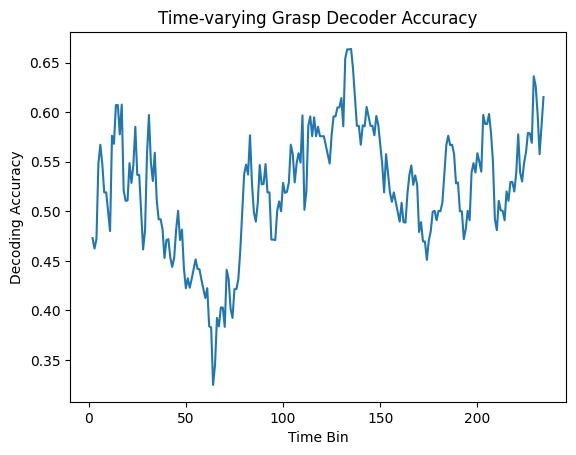

In [40]:

time_pts, accs = time_varying_decoder(neural_data, grasp_type, window_size=5, model='knn', n_neighbors=3)

import matplotlib.pyplot as plt
plt.plot(time_pts, accs)
plt.xlabel('Time Bin')
plt.ylabel('Decoding Accuracy')
plt.title('Time-varying Grasp Decoder Accuracy')
plt.show()


Starting decoding (mode = 'flatten', model = 'nb')...


Decoding Progress: 100%|██████████| 233/233 [00:04<00:00, 55.84it/s]


Decoding complete.


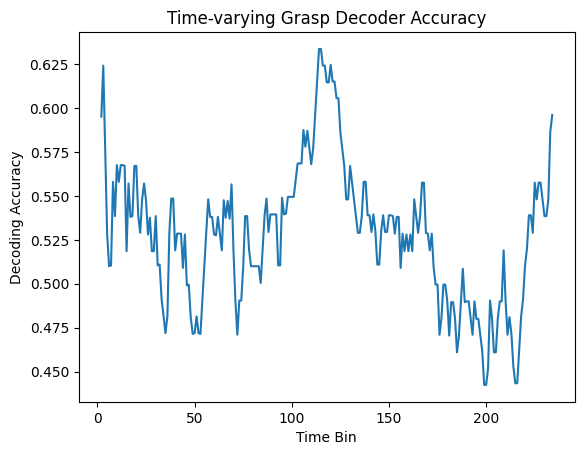

In [41]:

time_pts, accs = time_varying_decoder(neural_data, grasp_type, window_size=5, model='nb')

# Optional: plot the decoding accuracy over time
import matplotlib.pyplot as plt
plt.plot(time_pts, accs)
plt.xlabel('Time Bin')
plt.ylabel('Decoding Accuracy')
plt.title('Time-varying Grasp Decoder Accuracy')
plt.show()


Plot kinematic target locations

---



# Standard Kalman Filter

---



Format Input (neural data)

In [18]:
# matrix of neural features for all electrodes over time
X_kf = neural_data


Format Output (kinematic target data) to Include Position & Acceleration

In [30]:

y_kf = targ


In [31]:

bin_width = 0.032 # bin width in sec (useful for computing position from velocity data)
targ_pos_binned = targ

y_kf = extend_kinematics_from_position(targ_pos_binned = targ_pos_binned,
                                       bin_width       = bin_width,
                                       compute         = 'velocity') # velocity


In [32]:
y_feedback = targ_feedback

Train-test split

In [33]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_kf_train, X_kf_test, y_kf_train, y_kf_test, y_feedback_train, y_feedback_test, = train_test_split(X_kf, y_kf, y_feedback, test_size=0.15, shuffle=False, random_state=42)


### Optimize Kalman Parameters

---



In [66]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # Import tqdm for progress bar

# Define the parameter grid to search
param_grid = {
    'C': np.arange(0.05, 10, 0.05),  # Values for C
    'O': [1]      # Values for O np.arange(1, 5, 1)
}

# Create a list to store results
results = []

# Iterate through the parameter combinations with progress bar
for params in tqdm(ParameterGrid(param_grid), desc="Optimizing Kalman Filter"):
    # Initialize and train the Kalman Filter
    model_kf = KalmanFilter(C=params['C'], O=params['O'])
    model_kf.fit(X_kf_train, y_feedback_train)

    # Make predictions on the test set
    y_pred_kf_test = model_kf.predict(X_kf_test)

    # Calculate R² score
    r2   = r2_score(y_kf_test, y_pred_kf_test, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_kf_test, y_pred_kf_test, multioutput='raw_values'))

    # Store the results
    results.append({
        'C': params['C'],
        'O': params['O'],
        'R²_fing1': r2[0],
        'R²_fing2': r2[1],
        'R²': np.mean(r2[:2]),
        'RMSE_fing1': rmse[0],
        'RMSE_fing2': rmse[1],
        'RMSE': np.mean(rmse[:2])
    })

# Find the best parameters
best_params = min(results, key=lambda x: x['RMSE'])


Optimizing Kalman Filter: 100%|██████████| 199/199 [03:41<00:00,  1.12s/it]


In [67]:
# Print parameter tuning results
print("Best parameters:\n")
print("-------------------")
[print(f"{key}: {best_params[key]:.4f}") for key in best_params]


Best parameters:

-------------------
C: 6.5000
O: 1.0000
R²_fing1: 0.1799
R²_fing2: 0.6055
R²: 0.3927
RMSE_fing1: 0.2000
RMSE_fing2: 0.1421
RMSE: 0.1711


[None, None, None, None, None, None, None, None]

In [68]:
import pandas as pd

tuning_results = pd.DataFrame(results)
tuning_results.sort_values(by='R²', ascending=False, inplace=True)
tuning_results.head(20)
# tuning_results.reset_index(drop=True, inplace=True)

,C,O,R²_fing1,R²_fing2,R²,RMSE_fing1,RMSE_fing2,RMSE
131,6.60,1,0.180175,0.605243,0.392709,0.200011,0.142137,0.171074
132,6.65,1,0.180317,0.605099,0.392708,0.199994,0.142163,0.171078
130,6.55,1,0.180025,0.605376,0.392701,0.200030,0.142113,0.171071
133,6.70,1,0.180450,0.604945,0.392697,0.199978,0.142190,0.171084
129,6.50,1,0.179867,0.605500,0.392683,0.200049,0.142090,0.171070
134,6.75,1,0.180575,0.604781,0.392678,0.199963,0.142220,0.171091
128,6.45,1,0.179699,0.605613,0.392656,0.200069,0.142070,0.171070
135,6.80,1,0.180693,0.604608,0.392650,0.199948,0.142251,0.171100
127,6.40,1,0.179523,0.605715,0.392619,0.200091,0.142052,0.171071
136,6.85,1,0.180802,0.604425,0.392613,0.199935,0.142284,0.171109


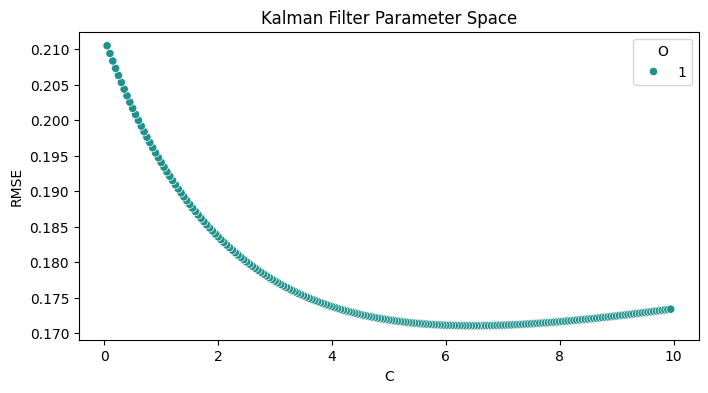

In [69]:
# tuning_results.plot(x='C', y='RMSE', kind='scatter', hue='O')
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.scatterplot(x='C', y='RMSE', hue='O', palette='viridis', data=tuning_results)

# sns.lineplot(x='C', y='R²_fing1', hue='O', palette='viridis', data=tuning_results)
# sns.lineplot(x='C', y='R²_fing2:', hue='O', palette='viridis', data=tuning_results)

plt.title('Kalman Filter Parameter Space')
plt.show()


### Run Kalman Filter

---



In [86]:
# Initialize filter
model_kf = KalmanFilter(C=.1, O=1) # Kalman filter with precomputed initial state. (Initial state computed during training)
# C controls the smoothing: larger values = more smoothing of the (target) predictions

# Fit model
# model_kf.fit(X_kf_train,y_kf_train)
model_kf.fit(X_kf_train, y_feedback_train, use_PCA_TF=False, PC_thresh=0.8)

y_pred_kf_train = model_kf.predict(X_kf_train)
y_pred_kf_test  = model_kf.predict(X_kf_test)


### Kalman Filter Electrode Weights

---



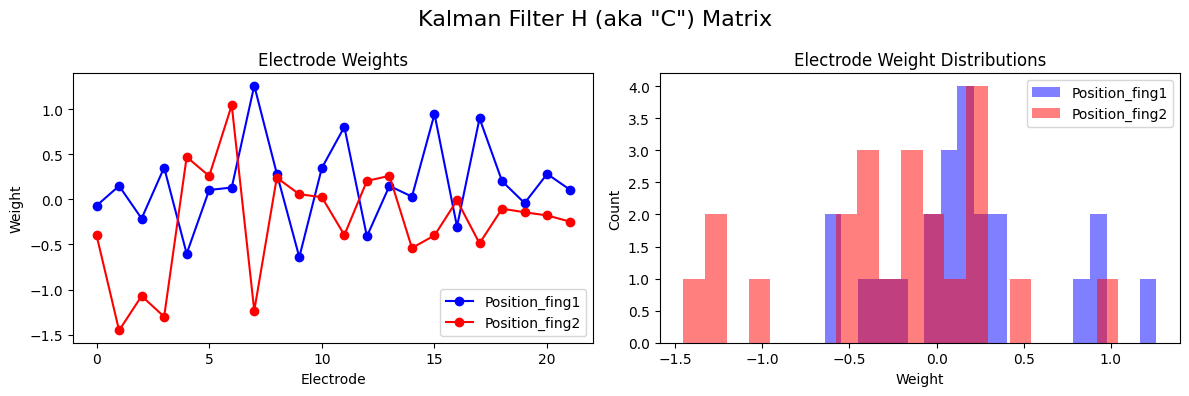

In [42]:
# H represents the transformation that converts kinematics to neural features
H = model_kf.model['H'] # N x 4 for N electrodes [pos_1, pos_2, vel_1, vel_2]

fig, axes = plt.subplots(1,2, figsize=(12, 4))

axes[0].plot(H[:, 0], marker='o', linestyle='-', color='b', label='Position_fing1')
axes[0].plot(H[:, 1], marker='o', linestyle='-', color='r', label='Position_fing2')
axes[0].set_title('Electrode Weights')
axes[0].set_xlabel('Electrode')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].grid(False)

axes[1].hist(H[:, 0], bins=20, color='b', alpha=0.5, label='Position_fing1')
axes[1].hist(H[:, 1], bins=20, color='r', alpha=0.5, label='Position_fing2')
axes[1].set_title('Electrode Weight Distributions')
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].grid(False)

plt.suptitle('Kalman Filter H (aka "C") Matrix', fontsize=16)
plt.tight_layout()
plt.show()


In [345]:
W_thresh = 0.5
best_chans = np.where((np.abs(H[:, 0]) >= W_thresh) | (np.abs(H[:, 1]) >= W_thresh))[0]
best_chans


array([ 0,  2,  3,  4,  6,  7, 10, 11, 14, 31, 32, 34, 52, 64, 66, 67, 69,
       70, 71, 73, 77, 78, 79, 80, 83])

### Run ReFIT Kalman

---



In [339]:
# ==== ReFIT Kalman Filter ====
# targets = ground truth target kinematics

# ---- ReFIT Kalman Filter ----
refit_kf = ReFITKalmanFilter(
    C=0.25,
    velocity_rot_method   = "rotate",  # options: "flip", "rotate"
    zero_vel_on_target_TF = True # This parameter doesn't seem too consequential. Just leave it at true
)

# Train using intention-aligned velocities
refit_kf.fit(X_kf_train, y_feedback_train, targets = y_kf_train, targsize=0.075)

# Predict on test neural data
y_pred_kf_train = refit_kf.predict(X_kf_train)
y_pred_kf_test  = refit_kf.predict(X_kf_test)


### Evaluate model performance

---



In [87]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_kf_train, y_pred_kf_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_kf_test, y_pred_kf_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_kf_train, y_pred_kf_train, multioutput='raw_values') # 1 x 6 (pos_1, pos_2, vel_1, vel_2, acc_1, acc_2)
test_r2_list    = r2_score(y_kf_test, y_pred_kf_test, multioutput='raw_values')

from IPython.display import clear_output
# clear_output()

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1821
Train R²: -0.0157
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1837
Test R²: 0.3407


Plot Offline Target Predictions

---



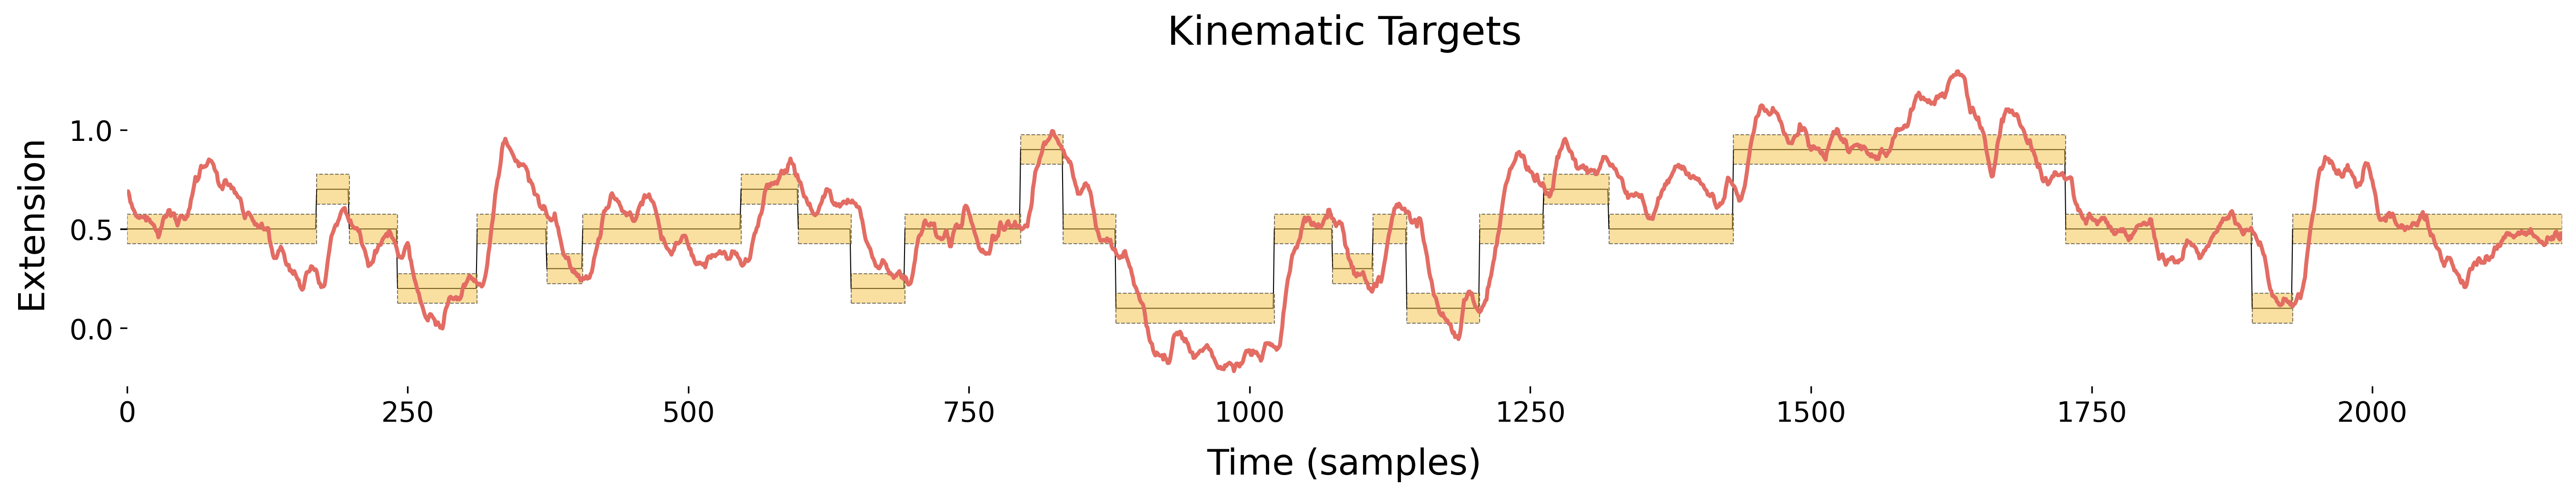


Offline R²: 0.3407


In [88]:
fing = 1 # select finger to plot
targ_vel      = y_kf_test[:,fing]
targ_vel_pred = y_pred_kf_test[:,fing]
# y_kf_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2, acc_1, acc_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
            #  x_lim        = (0,2000),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


Plot Online Target Predictions

---



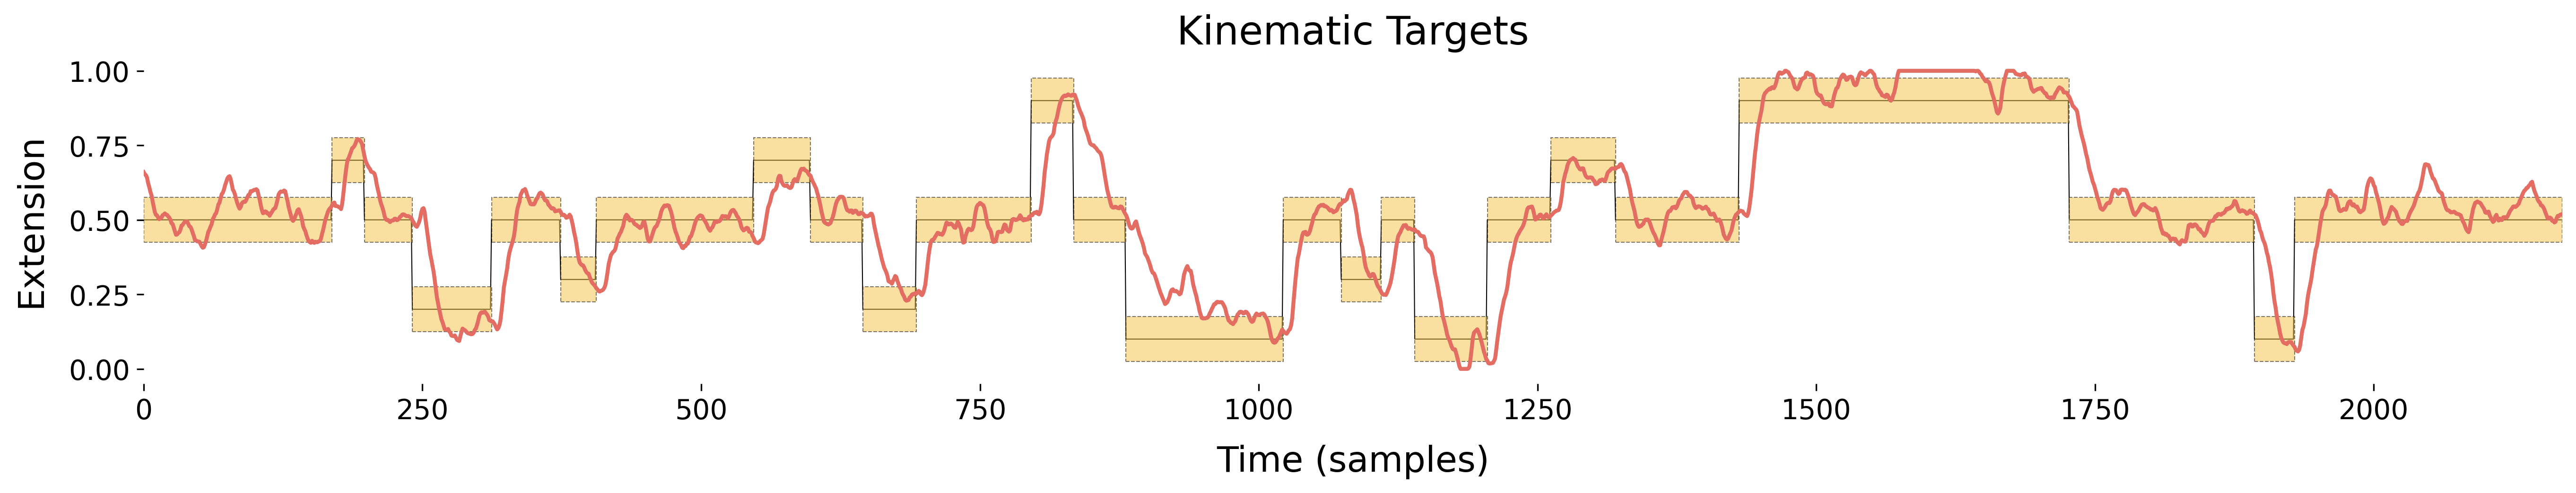


Online R²: 0.6438


In [94]:
fing = 1 # select finger to plot

targ_vel      = y_kf_test[:,fing]
targ_vel_pred = y_feedback_test[:,fing]
# targ_vel is time_bins x 4 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
            #  x_lim        = (0,2000),
             plot_targ_TF = True)

print(f"\nOnline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# Wiener Filter

---



Prepare data for modeling

In [135]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)


Run Wiener Filter

---



In [136]:
#Declare model
model_wf = WienerFilterDecoder()

num_bins_before = 5
#Fit model
model_wf.fit(X_train,y_train, num_bins_before = num_bins_before)

# Get predictions
y_pred_train = model_wf.predict(X_train)
y_pred_test  = model_wf.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]

# from IPython.display import clear_output
# clear_output()


Evaluate model performance

---



In [137]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1338
Train R²: 0.4517
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1676
Test R²: 0.4524


Plot Offline Target Predictions

---



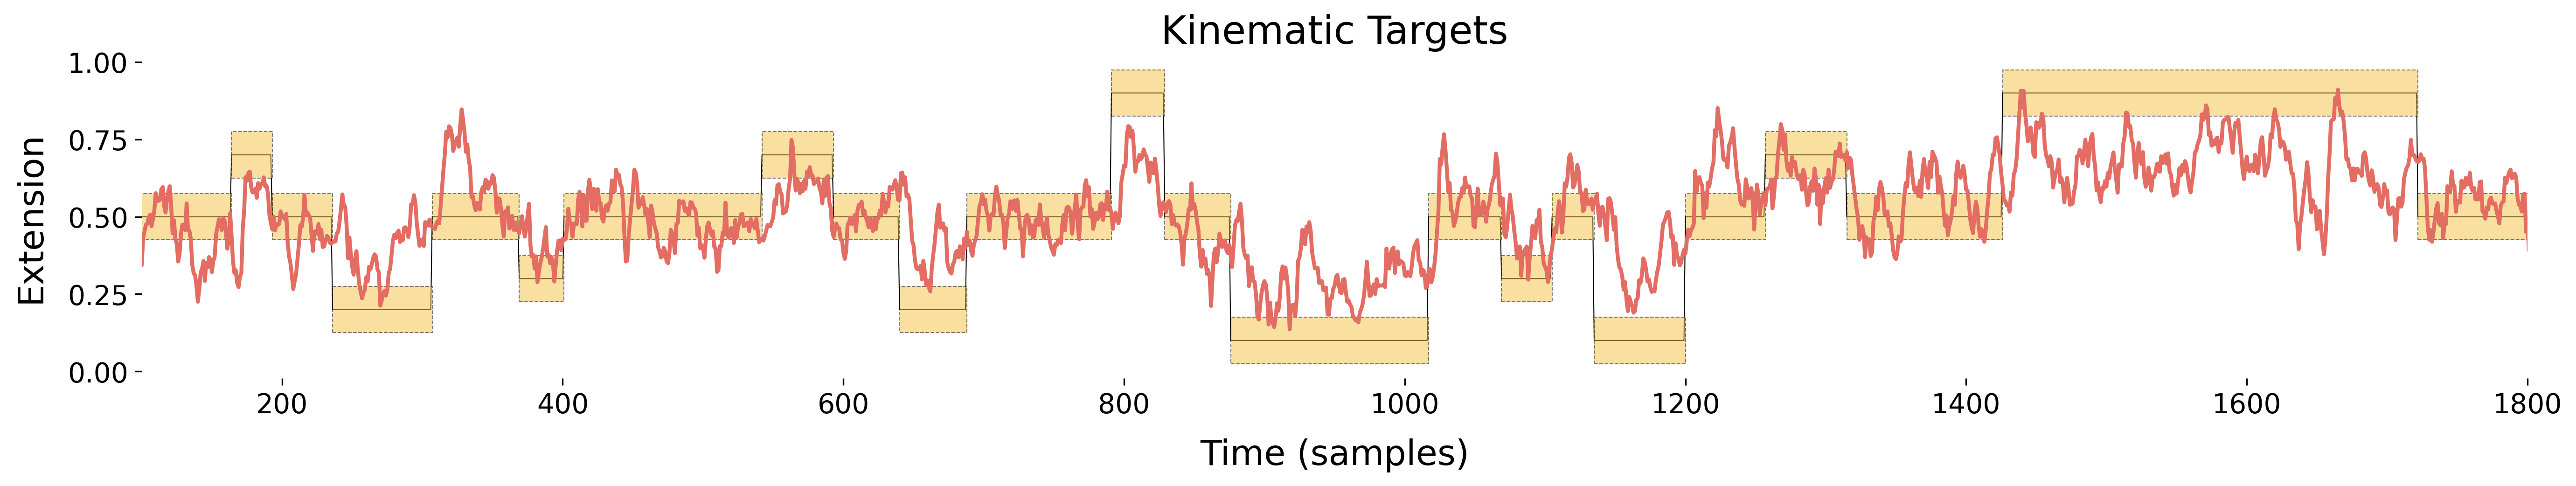


Offline R²: 0.4524


In [138]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# Ridge Regression Decoder

---



Prepare data for modeling

In [183]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)


Run Ridge Regression Decoder

---



In [184]:
#Declare model
model_rr = RidgeDecoder(alpha=0.01)

num_bins_before = 10
#Fit model
model_rr.fit(X_train,y_train, num_bins_before = num_bins_before)

# Get predictions
y_pred_train = model_rr.predict(X_train)
y_pred_test  = model_rr.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]


Evaluate model performance

---



In [185]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1236
Train R²: 0.5330
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1603
Test R²: 0.5001


Plot Offline Target Predictions

---



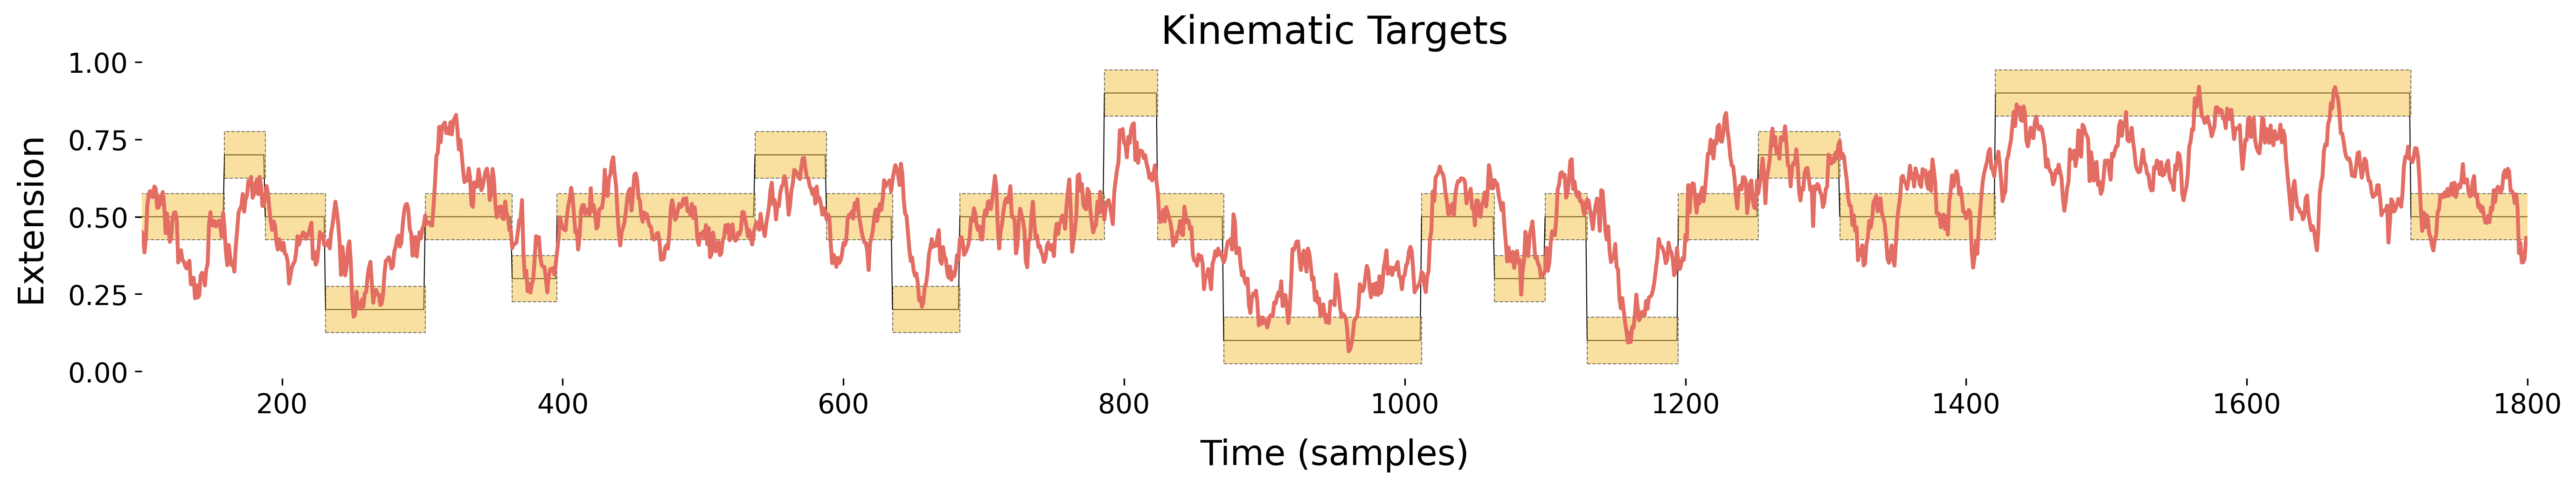


Offline R²: 0.5001


In [186]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# XGBoost Decoder

---



In [242]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False, random_state=42)


In [243]:
# Declare model

num_bins_before = 15
model_xgb = XGBoostMultiOutputDecoder(
    max_depth       = 2,
    eta             = 0.1, # Learning rate
    subsample       = 0.3, # Fraction of samples (rows) randomly selected for training each tree.
    colsample_bytree= 0.1, # Fraction of features (columns) randomly selected for training each tree.
    min_child_weight= 10, # minimum number of instances needed to be in each node.
    num_round       = 500, # Number of boosting rounds
    num_bins_before = num_bins_before,
    patience        = 50,
    val_verbose     = 1
)

model_xgb.fit(X_train, y_train, X_val=X_val, y_val=y_val)

# Get predictions
y_pred_train = model_xgb.predict(X_train)
y_pred_test  = model_xgb.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]

from IPython.display import clear_output
clear_output()


Evaluate model performance

---



In [239]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1104
Train R²: 0.6327
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1593
Test R²: 0.5078


Plot Offline Target Predictions

---



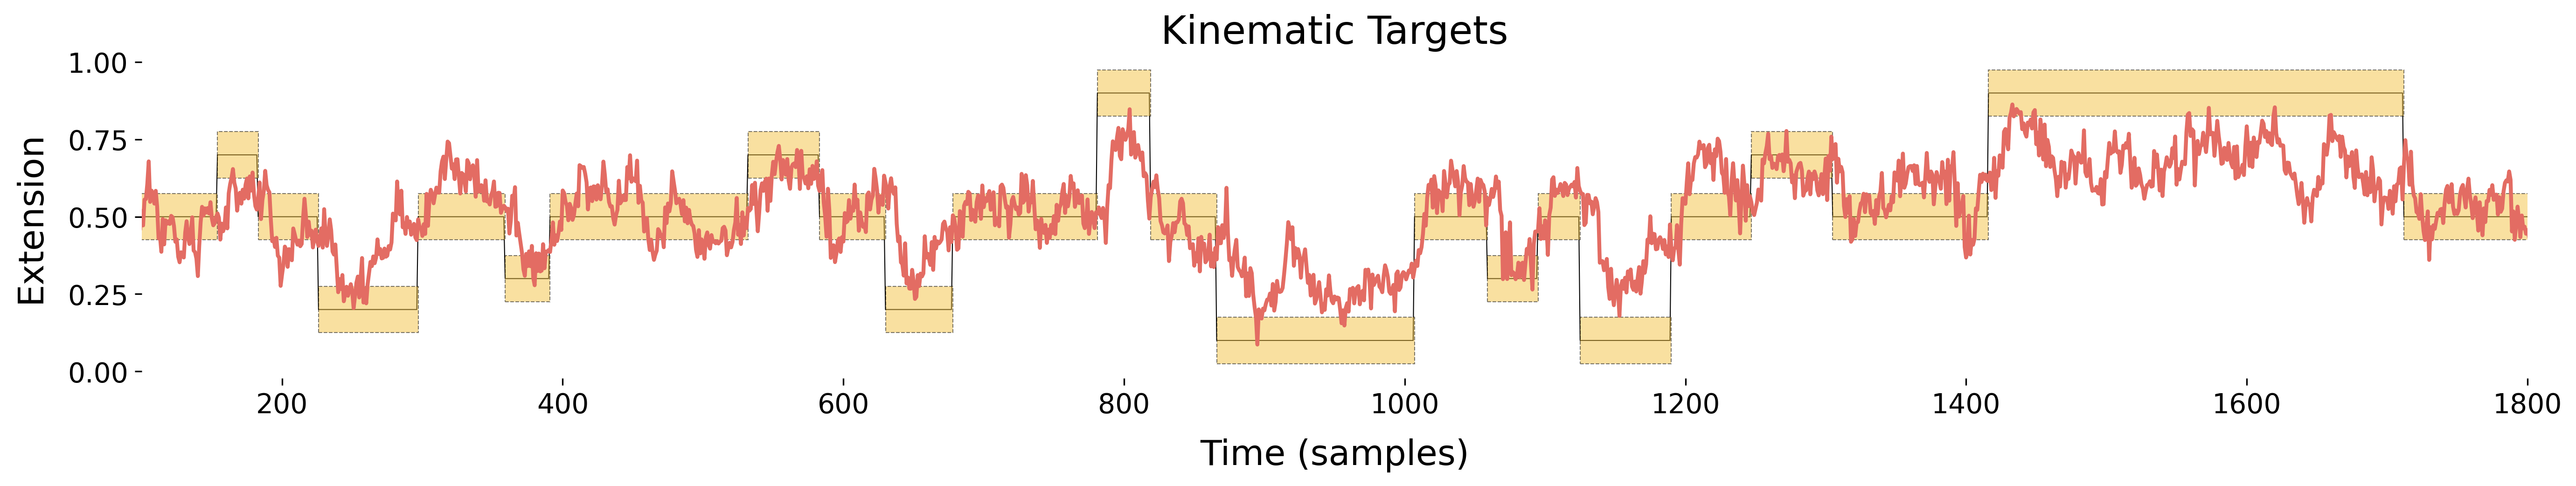


Offline R²: 0.5079


In [240]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# FeedForward Neural Network

---



In [ ]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False, random_state=42)

In [ ]:
# Declare model
model_ffn = FeedForwardNNDecoder(units      = 256,
                                 dropout    = 0.5,
                                 batch_size = 512,
                                 num_epochs = 500,
                                 verbose    = 1)

# Fit model
num_bins_before = 10
model_ffn.fit(X_train, y_train,
              val_data = [X_val, y_val],
              early_stopping_TF = True,
              patience = 15,
              num_bins_before = num_bins_before)

# Get predictions
y_pred_train = model_ffn.predict(X_train)
y_pred_test  = model_ffn.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]

# from IPython.display import clear_output
# clear_output()


### Evaluate model performance

---



In [ ]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1256
Train R²: 0.5239
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1672
Test R²: 0.4552


### Plot Offline Target Predictions

---



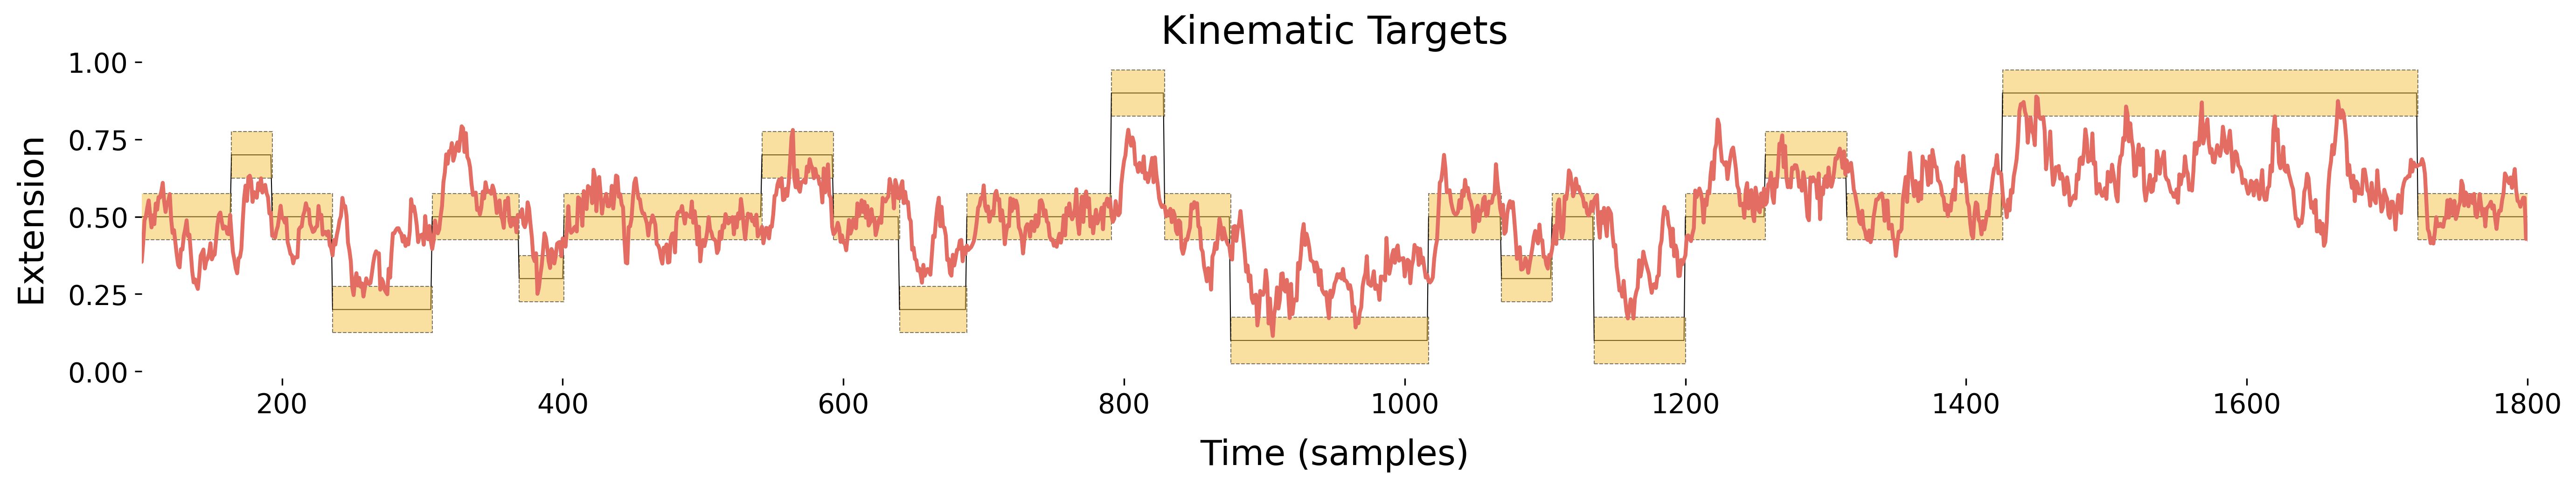


Offline R²: 0.4552


In [ ]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (100,1800),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")


# CNN-FeedForward Hybrid Neural Network

---



In [154]:
from sklearn.model_selection import train_test_split

# Split all data into train and test
X_train, X_test, y_train, y_test = train_test_split(neural_data, targ, test_size=0.15, shuffle=False, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=False, random_state=42)
print("X_train shape: ", X_train.shape)


X_train shape:  (10446, 96)


### Optimize Hyperparameters

---



In [108]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # Import tqdm for progress bar

# Define the parameter grid to search
param_grid = {
    'learning_rate': np.linspace(0.01, 0.0001, 25),  # np.arange(1, 10, 2)*1e-2, np.logspace(-5,-1,5)
    'dropout_rate': [0.3,0.4],      # np.arange(0.2, 0.6, 0.1)
    'num_bins_before': [15]  # np.arange(3, 15, 3)
}

# Create a list to store results
results = []

# Iterate through the parameter combinations with progress bar
for params in tqdm(ParameterGrid(param_grid), desc="Optimizing CNN-FFNN Architecture"):

    # -----------
    # Declare model
    model_cffn = CNN_FeedForwardNNDecoder(
        hidden_size     = 256,
        ConvSizeOut     = params['num_bins_before'],
        learning_rate   = params['learning_rate'],
        dropout_rate    = params['dropout_rate'],
        num_bins_before = params['num_bins_before']
    )

    # Fit model
    model_cffn.fit(
        X_train, y_train,
        use_PCA_TF      = True,
        PC_thresh       = 10,
        validation_data = (X_val, y_val),
        epochs          = 250,
        batch_size      = 300,
        early_stopping  = True,
        patience        = 10,
        verbose         = 0
    )
    # -----------
    # Make predictions on the test set
    y_pred_test = model_cffn.predict(X_test)

    # Trim y_test to match the length of y_pred_test
    y_test_trimmed = y_test[params['num_bins_before']:] # remove first num_bins_before rows to match prediction data

    # Calculate R² score
    r2   = r2_score(y_test_trimmed, y_pred_test, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test_trimmed, y_pred_test, multioutput='raw_values'))

    # Plot param values and performance metrics at current iteration
    print(f"\nbins: {params['num_bins_before']}, lr: {params['learning_rate']}, dr: {params['dropout_rate']:.2f} | R²: {np.mean(r2[:2]):.2f}, RMSE: {np.mean(rmse[:2]):.2f}")

    # Store the results
    results.append({
        'num_bins': params['num_bins_before'],
        'learn_rate': params['learning_rate'],
        'dropout': params['dropout_rate'],
        'R²_fing1': r2[0],
        'R²_fing2': r2[1],
        'R²': np.mean(r2[:2]),
        'RMSE_fing1': rmse[0],
        'RMSE_fing2': rmse[1],
        'RMSE': np.mean(rmse[:2])
    })

# Find the best parameters
best_params = max(results, key=lambda x: x['R²'])


Optimizing CNN-FFNN Architecture:   0%|          | 0/50 [00:00<?, ?it/s]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:   2%|▏         | 1/50 [00:29<24:18, 29.77s/it]


bins: 15, lr: 0.01, dr: 0.30 | R²: 0.39, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:   4%|▍         | 2/50 [01:01<24:37, 30.79s/it]


bins: 15, lr: 0.0095875, dr: 0.30 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:   6%|▌         | 3/50 [01:31<24:04, 30.74s/it]


bins: 15, lr: 0.009175, dr: 0.30 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:   8%|▊         | 4/50 [02:01<23:19, 30.41s/it]


bins: 15, lr: 0.0087625, dr: 0.30 | R²: 0.42, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  10%|█         | 5/50 [02:35<23:47, 31.71s/it]


bins: 15, lr: 0.00835, dr: 0.30 | R²: 0.46, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  12%|█▏        | 6/50 [03:06<23:03, 31.44s/it]


bins: 15, lr: 0.0079375, dr: 0.30 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Optimizing CNN-FFNN Architecture:  14%|█▍        | 7/50 [03:38<22:29, 31.39s/it]


bins: 15, lr: 0.0075250000000000004, dr: 0.30 | R²: 0.39, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  16%|█▌        | 8/50 [04:06<21:22, 30.53s/it]


bins: 15, lr: 0.0071125, dr: 0.30 | R²: 0.41, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  18%|█▊        | 9/50 [04:46<22:47, 33.36s/it]


bins: 15, lr: 0.006699999999999999, dr: 0.30 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  20%|██        | 10/50 [05:17<21:50, 32.76s/it]


bins: 15, lr: 0.0062875, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  22%|██▏       | 11/50 [05:54<22:08, 34.07s/it]


bins: 15, lr: 0.005875, dr: 0.30 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  24%|██▍       | 12/50 [06:25<21:00, 33.17s/it]


bins: 15, lr: 0.0054624999999999995, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  26%|██▌       | 13/50 [07:02<21:07, 34.26s/it]


bins: 15, lr: 0.00505, dr: 0.30 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  28%|██▊       | 14/50 [07:36<20:26, 34.07s/it]


bins: 15, lr: 0.004637499999999999, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Optimizing CNN-FFNN Architecture:  30%|███       | 15/50 [08:11<20:03, 34.39s/it]


bins: 15, lr: 0.004225, dr: 0.30 | R²: 0.46, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Optimizing CNN-FFNN Architecture:  32%|███▏      | 16/50 [08:46<19:33, 34.50s/it]


bins: 15, lr: 0.003812499999999999, dr: 0.30 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  34%|███▍      | 17/50 [09:22<19:14, 34.98s/it]


bins: 15, lr: 0.0033999999999999994, dr: 0.30 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  36%|███▌      | 18/50 [10:01<19:18, 36.22s/it]


bins: 15, lr: 0.0029874999999999997, dr: 0.30 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  38%|███▊      | 19/50 [10:43<19:41, 38.10s/it]


bins: 15, lr: 0.002574999999999999, dr: 0.30 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  40%|████      | 20/50 [11:37<21:23, 42.80s/it]


bins: 15, lr: 0.0021624999999999995, dr: 0.30 | R²: 0.48, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Optimizing CNN-FFNN Architecture:  42%|████▏     | 21/50 [12:18<20:28, 42.35s/it]


bins: 15, lr: 0.0017499999999999998, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  44%|████▍     | 22/50 [13:08<20:44, 44.44s/it]


bins: 15, lr: 0.0013374999999999984, dr: 0.30 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  46%|████▌     | 23/50 [14:21<23:49, 52.94s/it]


bins: 15, lr: 0.0009249999999999987, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  48%|████▊     | 24/50 [15:28<24:48, 57.25s/it]


bins: 15, lr: 0.0005124999999999991, dr: 0.30 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  50%|█████     | 25/50 [18:24<38:40, 92.83s/it]


bins: 15, lr: 0.0001, dr: 0.30 | R²: 0.41, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  52%|█████▏    | 26/50 [18:56<29:55, 74.82s/it]


bins: 15, lr: 0.01, dr: 0.40 | R²: 0.41, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  54%|█████▍    | 27/50 [19:25<23:20, 60.91s/it]


bins: 15, lr: 0.0095875, dr: 0.40 | R²: 0.39, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  56%|█████▌    | 28/50 [19:53<18:44, 51.10s/it]


bins: 15, lr: 0.009175, dr: 0.40 | R²: 0.39, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  58%|█████▊    | 29/50 [20:22<15:31, 44.34s/it]


bins: 15, lr: 0.0087625, dr: 0.40 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  60%|██████    | 30/50 [20:50<13:07, 39.39s/it]


bins: 15, lr: 0.00835, dr: 0.40 | R²: 0.43, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  62%|██████▏   | 31/50 [21:19<11:29, 36.28s/it]


bins: 15, lr: 0.0079375, dr: 0.40 | R²: 0.38, RMSE: 0.18
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Optimizing CNN-FFNN Architecture:  64%|██████▍   | 32/50 [22:00<11:21, 37.87s/it]


bins: 15, lr: 0.0075250000000000004, dr: 0.40 | R²: 0.41, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  66%|██████▌   | 33/50 [22:37<10:40, 37.66s/it]


bins: 15, lr: 0.0071125, dr: 0.40 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  68%|██████▊   | 34/50 [23:09<09:34, 35.93s/it]


bins: 15, lr: 0.006699999999999999, dr: 0.40 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  70%|███████   | 35/50 [23:39<08:31, 34.11s/it]


bins: 15, lr: 0.0062875, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  72%|███████▏  | 36/50 [24:15<08:05, 34.71s/it]


bins: 15, lr: 0.005875, dr: 0.40 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Optimizing CNN-FFNN Architecture:  74%|███████▍  | 37/50 [24:54<07:48, 36.03s/it]


bins: 15, lr: 0.0054624999999999995, dr: 0.40 | R²: 0.40, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  76%|███████▌  | 38/50 [25:33<07:20, 36.73s/it]


bins: 15, lr: 0.00505, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  78%|███████▊  | 39/50 [26:09<06:43, 36.70s/it]


bins: 15, lr: 0.004637499999999999, dr: 0.40 | R²: 0.46, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  80%|████████  | 40/50 [26:51<06:22, 38.25s/it]


bins: 15, lr: 0.004225, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Optimizing CNN-FFNN Architecture:  82%|████████▏ | 41/50 [27:22<05:25, 36.15s/it]


bins: 15, lr: 0.003812499999999999, dr: 0.40 | R²: 0.42, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  84%|████████▍ | 42/50 [27:59<04:49, 36.20s/it]


bins: 15, lr: 0.0033999999999999994, dr: 0.40 | R²: 0.47, RMSE: 0.16
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  86%|████████▌ | 43/50 [28:39<04:21, 37.33s/it]


bins: 15, lr: 0.0029874999999999997, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  88%|████████▊ | 44/50 [29:25<04:00, 40.13s/it]


bins: 15, lr: 0.002574999999999999, dr: 0.40 | R²: 0.42, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Optimizing CNN-FFNN Architecture:  90%|█████████ | 45/50 [30:11<03:29, 41.83s/it]


bins: 15, lr: 0.0021624999999999995, dr: 0.40 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  92%|█████████▏| 46/50 [31:01<02:57, 44.32s/it]


bins: 15, lr: 0.0017499999999999998, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture:  94%|█████████▍| 47/50 [32:10<02:35, 51.69s/it]


bins: 15, lr: 0.0013374999999999984, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  96%|█████████▌| 48/50 [33:31<02:00, 60.44s/it]


bins: 15, lr: 0.0009249999999999987, dr: 0.40 | R²: 0.45, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Optimizing CNN-FFNN Architecture:  98%|█████████▊| 49/50 [34:54<01:07, 67.13s/it]


bins: 15, lr: 0.0005124999999999991, dr: 0.40 | R²: 0.44, RMSE: 0.17
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Optimizing CNN-FFNN Architecture: 100%|██████████| 50/50 [37:36<00:00, 45.13s/it]


bins: 15, lr: 0.0001, dr: 0.40 | R²: 0.40, RMSE: 0.17


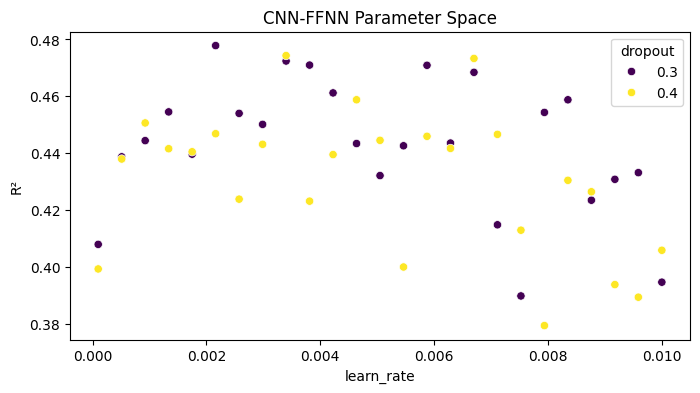

In [112]:
import pandas as pd
tuning_results = pd.DataFrame(results)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
# sns.scatterplot(x='learn_rate', y='R²', hue='dropout', style='num_bins', palette='viridis', data=tuning_results)
sns.scatterplot(x='learn_rate', y='R²', hue='dropout', palette='viridis', data=tuning_results)
plt.title('CNN-FFNN Parameter Space')
# plt.xlim(-0.1,0.2)
# plt.xscale('log')
plt.show()


array([0.01  , 0.0089, 0.0078, 0.0067, 0.0056, 0.0045, 0.0034, 0.0023,
       0.0012, 0.0001])

### Fit Model

---



In [155]:
num_bins_before = 15

# Declare model
model_cffn = CNN_FeedForwardNNDecoder(
    hidden_size     = 256,
    ConvSizeOut     = num_bins_before,
    learning_rate   = 0.002, # max: 0.01, min: 0.0001, ideal: 0.002
    dropout_rate    = 0.35, # ideal: 0.3
    num_bins_before = num_bins_before
)

# Fit model
model_cffn.fit(
    X_train, y_train,
    use_PCA_TF      = True,
    PC_thresh       = 50,
    validation_data = (X_val, y_val),
    epochs          = 500,
    batch_size      = 512,
    early_stopping  = True,
    patience        = 50
)

# Get predictions
y_pred_train = model_cffn.predict(X_train)
y_pred_test  = model_cffn.predict(X_test)

# Re-format target data
y_train = y_train[num_bins_before:,:]
y_test  = y_test[num_bins_before:,:]

from IPython.display import clear_output
clear_output()


### Evaluate model performance

---



In [156]:
# --------------- Evaluate model performance ----------------
from sklearn.metrics import mean_squared_error, r2_score

fing = 1  # select finger to plot
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2_list   = r2_score(y_train, y_pred_train, multioutput='raw_values') # 1 x 4 (pos_1, pos_2, vel_1, vel_2)
test_r2_list    = r2_score(y_test, y_pred_test, multioutput='raw_values')

print(f"----------- PERFORMANCE METRICS: TRAINING SET (Finger {fing+1}) ---------------")
print(f"Train RMSE: {train_rmse[fing]:.4f}")
print(f"Train R²: {train_r2_list[fing]:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET (Finger {fing+1}) ---------------")
print(f"Test RMSE: {test_rmse[fing]:.4f}")
print(f"Test R²: {test_r2_list[fing]:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET (Finger 2) ---------------
Train RMSE: 0.1029
Train R²: 0.6806
----------- PERFORMANCE METRICS: TEST SET (Finger 2) ---------------
Test RMSE: 0.1527
Test R²: 0.5475


### Plot Offline Target Predictions

---



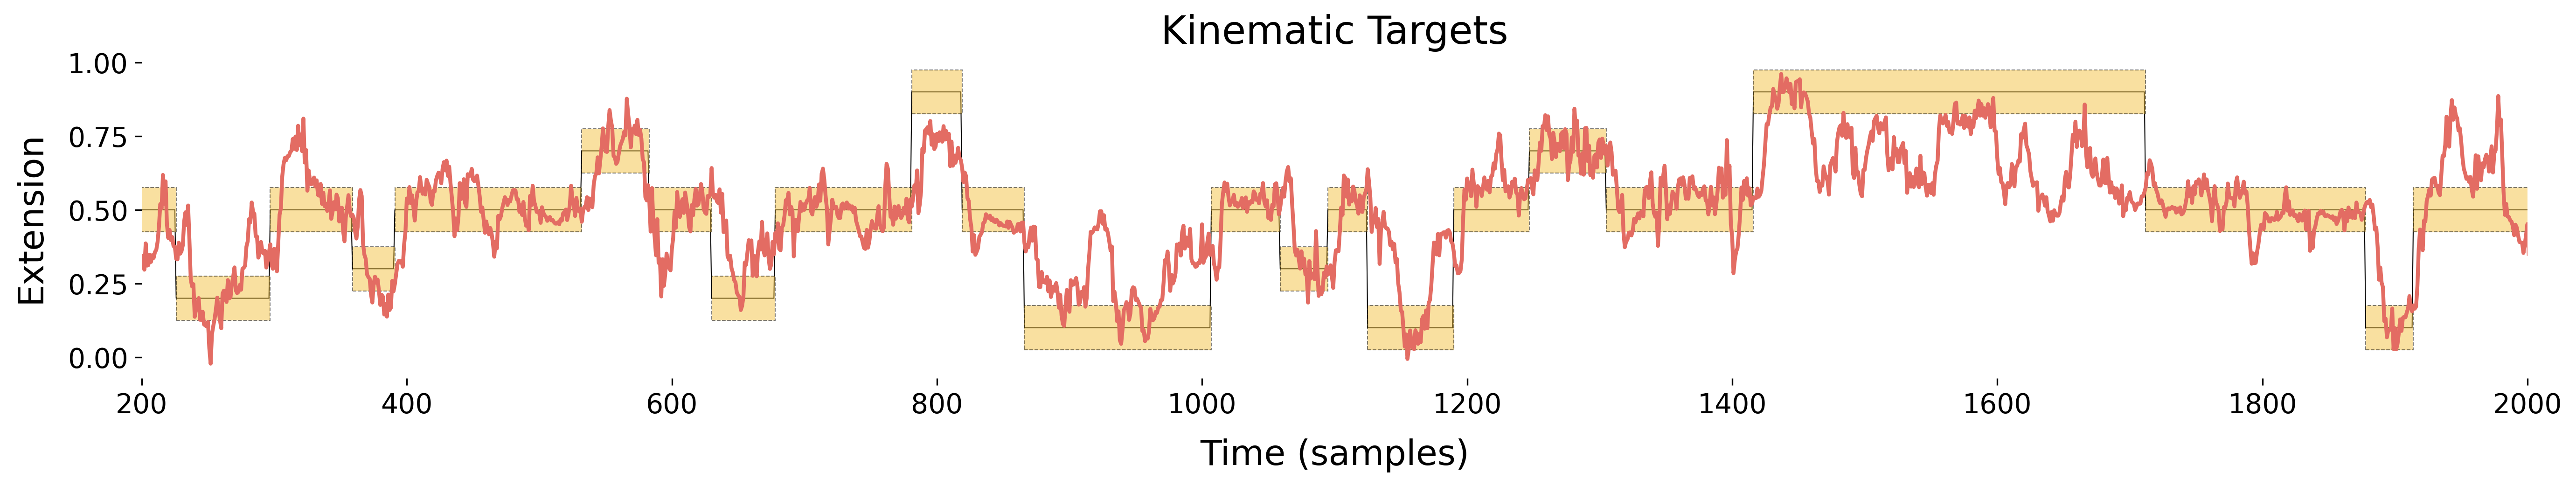


Offline R²: 0.5400


In [153]:
fing = 1 # select finger to plot
targ_vel      = y_test[:,fing]
targ_vel_pred = y_pred_test[:,fing]
# y_pred_test is time_bins x 6 (pos_1, pos_2, vel_1, vel_2)

if fing == 0:
  fing_color = {'line': '#06ADA7', 'target': '#9CEAEF'}
elif fing == 1:
  fing_color = {'line': '#E36C63', 'target': '#F4C343'}
else:
  fing_color = {'line': 'k', 'target': 'k'}

plot_targets(targ         = targ_vel,
             y_pred       = targ_vel_pred,
             targ_radius  = targsize.mean(),
             fing_color   = fing_color,
             x_lim        = (200,2000),
             plot_targ_TF = True)

print(f"\nOffline R²: {r2_score(targ_vel,targ_vel_pred):.4f}")
